In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#### Load Feature Schema from json

In [2]:
rd_schema = pd.read_json('../data/raw/sipp_2018/pu2018_schema.json')
rd_schema['dtype'] = (['Int64' if x == 'integer'
                       else 'object' if x == 'string'
                       else 'Float64' if x == 'float'
                       else 'ERROR'
                       for x in rd_schema['dtype']]
                     )

#### Choose Features for Import

In [3]:
# This cell is for seleting which of the ~5,000 features to import

# Initialize lists with column names to read from csv into df

# Set of Standard columns suggested by SIPP documentation
std_cols = [#Common case-identification variables
    'SSUID','PNUM','MONTHCODE','ERESIDENCEID','ERELRPE','SPANEL','SWAVE',
    #The base weight and monthly in-survey-universe indicator
    'WPFINWGT','RIN_UNIV',
    #Additional variables for analysis
    'TPTOTINC','RTANF_MNYN']

# Set of Demographics columns
demo_cols = ['ESEX', 'TAGE', 'TRACE',          # sex, age @interview, detailed race
             'EORIGIN', 'TLANG1', 'EHOWWELL',  # hispanic origin, lang spoken @home, how well eng spoken
             'EBORNUS', 'ECITIZEN', 'ESPEAK',  # US born, US citizen, lang other than eng at home
             'RFAMKIND', 'EMS', 'EEDUC',       # family type, marital status, highest school/degree completed
             'RLNGISOL', 'TLIVQTR', 'ETENURE', 'ERACE'  # ltd eng household, type livng qtr, own/rent/other livng qtr
            ]

# Set of Stock and 401k ownership columns
st_own_cols = ['EOWN_ST', 'EOWN_THR401']       # own stocks, own 401k/tax-sheltered investment

collateralized_debt = ['EBOATDEBT', 'EMCYCDEBT', 'EMHLOAN1SITE', 'EPRDEBT', 'EPRLOAN1FXVR', 'EPRLOAN1RATE',
                      'EPRLOAN1TYPE', 'ERVDEBT', 'TBOATDEBTVAL', 'TBSI1DEBTVAL', 'TMCYCDEBTVAL', 'TDEBT_BUS', 'TDEBT_HOME',
                       'TDEBT_RE', 'TDEBT_SEC', 'TDEBT_VEH', 'TPRLOANAMT', 'TRVDEBTVAL']

unsecured_debt = ['EDEBT_CC', 'EDEBT_ED', 'EDEBT_MED', 'EJSCCDEBT', 'EJSEDDEBT', 'EJSOTDEBT', 'TDEBT_CC', 'TDEBT_ED',
                 'TDEBT_OT', 'TDEBT_BUS', 'TDEBT_AST', 'TDEBT_RENT', 'TDEBT_USEC']

arthur_boat_bonus = ['EREC_BOAT', 'TBOATVAL']

harrison_cols = collateralized_debt + unsecured_debt + arthur_boat_bonus

# Concatenate columns to import
use_cols = std_cols + demo_cols + st_own_cols + harrison_cols

print(f'You are importing {len(use_cols)} columns')

You are importing 62 columns


#### Load Dataset to df

In [4]:
# Load dataset. This works on my computer (takes about 99 secs to load 26 columns).
start = time.time()
df = pd.read_csv("../data/raw/sipp_2018/pu2018-003.csv",
                      names=rd_schema['name'],
                      dtype=dict([(i,v) for i,v in zip(rd_schema.name, rd_schema.dtype)]),
                      sep='|',
                      header=0,
                      usecols=use_cols,
                     )
end = time.time()
print(f'Read with Pandas: {end - start} seconds')

Read with Pandas: 63.74114799499512 seconds


#### Reformat df Column Names

In [5]:
# Rename columns to Python friendly format and display df
df.columns = [name.lower().replace(' ', '_') for name in df.columns]
df.head()

,ssuid,spanel,swave,etenure,eprdebt,eprloan1rate,eprloan1fxvr,eprloan1type,emhloan1site,erec_boat,...,tdebt_cc,tdebt_ed,tdebt_ot,tdebt_usec,tdebt_bus,tdebt_home,tdebt_veh,tdebt_sec,tdebt_ast,tptotinc
0,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
1,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
2,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
3,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
4,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738


In [130]:
cols_to_exclude = ["spanel"]

for col in df.columns:
    if col not in cols_to_exclude:
        df[col] = df[col].fillna(0)
    #df.eprdebt.fillna(0).head(5)

df.head(5)

,ssuid,spanel,swave,etenure,eprdebt,eprloan1rate,eprloan1fxvr,eprloan1type,emhloan1site,erec_boat,...,tdebt_cc,tdebt_ed,tdebt_ot,tdebt_usec,tdebt_bus,tdebt_home,tdebt_veh,tdebt_sec,tdebt_ast,tptotinc
0,00011413607018,2018,1,2,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1738
1,00011413607018,2018,1,2,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1738
2,00011413607018,2018,1,2,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1738
3,00011413607018,2018,1,2,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1738
4,00011413607018,2018,1,2,0,0.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1738


In [6]:
(df
 .drop_duplicates()
 .eown_st
 .value_counts(normalize=True)
 .to_frame()
)

,eown_st
2,0.888283
1,0.111717


In [7]:
df.columns

Index(['ssuid', 'spanel', 'swave', 'etenure', 'eprdebt', 'eprloan1rate',
       'eprloan1fxvr', 'eprloan1type', 'emhloan1site', 'erec_boat',
       'emcycdebt', 'eboatdebt', 'ervdebt', 'pnum', 'ems', 'erelrpe', 'esex',
       'eorigin', 'erace', 'eeduc', 'espeak', 'ehowwell', 'rlngisol',
       'ebornus', 'ecitizen', 'eown_st', 'eown_thr401', 'edebt_cc', 'edebt_ed',
       'edebt_med', 'ejsccdebt', 'ejseddebt', 'ejsotdebt', 'monthcode',
       'wpfinwgt', 'eresidenceid', 'rfamkind', 'rtanf_mnyn', 'rin_univ',
       'tlang1', 'trace', 'tlivqtr', 'tboatval', 'tmcycdebtval',
       'tboatdebtval', 'trvdebtval', 'tbsi1debtval', 'tage', 'tprloanamt',
       'tdebt_rent', 'tdebt_re', 'tdebt_cc', 'tdebt_ed', 'tdebt_ot',
       'tdebt_usec', 'tdebt_bus', 'tdebt_home', 'tdebt_veh', 'tdebt_sec',
       'tdebt_ast', 'tptotinc'],
      dtype='object')

In [8]:
df.describe()

,spanel,swave,etenure,eprdebt,eprloan1rate,eprloan1fxvr,eprloan1type,emhloan1site,erec_boat,emcycdebt,...,tdebt_cc,tdebt_ed,tdebt_ot,tdebt_usec,tdebt_bus,tdebt_home,tdebt_veh,tdebt_sec,tdebt_ast,tptotinc
count,763186.0,763186.0,763186.000000,470013.000000,317315.000000,317315.000000,317315.000000,8334.000000,110788.000000,41720.000000,...,622464.000000,622464.000000,622464.000000,622464.000000,6.224640e+05,6.224640e+05,622464.000000,6.224640e+05,6.224640e+05,620018.000000
mean,2018.0,1.0,1.360748,1.324880,4.055775,1.095309,3.006155,2.504680,1.611510,1.864238,...,1699.454523,3573.963988,1026.797251,8252.094579,6.714226e+03,3.008260e+04,3165.297097,4.715519e+04,5.540728e+04,3575.846667
std,0.0,0.0,0.518481,0.468331,1.452144,0.356042,1.180132,0.541489,0.487409,0.342540,...,5212.404696,16939.253821,14900.177012,35066.451421,1.682829e+05,7.226394e+04,8970.198525,2.181896e+05,2.227698e+05,6822.266449
min,2018.0,1.0,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-126633.000000
25%,2018.0,1.0,1.000000,1.000000,3.400000,1.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,722.000000
50%,2018.0,1.0,1.000000,1.000000,4.000000,1.000000,3.000000,3.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.500000e+03,2112.000000
75%,2018.0,1.0,2.000000,2.000000,4.500000,1.000000,4.000000,3.000000,2.000000,2.000000,...,500.000000,0.000000,0.000000,3554.750000,0.000000e+00,2.350000e+04,0.000000,3.900000e+04,5.350000e+04,4336.000000
max,2018.0,1.0,3.000000,2.000000,25.000000,3.000000,4.000000,3.000000,2.000000,2.000000,...,72200.000000,235000.000000,417000.000000,892500.000000,8.401600e+06,1.070000e+06,361000.000000,1.041900e+07,1.083200e+07,518825.000000


In [119]:
sipp_2018_person = df.drop_duplicates(['ssuid', 'pnum'])

In [9]:
df.drop_duplicates(['ssuid', 'pnum']).trace.value_counts(normalize = True)
#corresponds to each person rather than households

1     0.777548
2     0.123085
4     0.056121
3     0.011453
7     0.009247
6     0.008308
8     0.004897
5     0.003114
10    0.001721
15    0.001299
9     0.001095
11    0.000501
14    0.000454
18    0.000297
16    0.000282
17    0.000219
19    0.000125
20    0.000094
12    0.000078
13    0.000031
21    0.000031
Name: trace, dtype: Float64

In [120]:
sipp_2018_person.trace.value_counts(normalize = True)

1     0.777548
2     0.123085
4     0.056121
3     0.011453
7     0.009247
6     0.008308
8     0.004897
5     0.003114
10    0.001721
15    0.001299
9     0.001095
11    0.000501
14    0.000454
18    0.000297
16    0.000282
17    0.000219
19    0.000125
20    0.000094
12    0.000078
13    0.000031
21    0.000031
Name: trace, dtype: Float64

In [10]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['trace']).eown_st.value_counts(normalize = True).unstack().sort_values(by = 1)

eown_st,1,2
trace,,
15,0.020833,0.979167
10,0.023529,0.976471
9,0.023810,0.976190
3,0.033392,0.966608
2,0.036264,0.963736
7,0.052854,0.947146
6,0.056818,0.943182
11,0.066667,0.933333
16,0.090909,0.909091


In [11]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).eown_st.value_counts(normalize = True).unstack().sort_values(by = 1)

eown_st,1,2
erace,,
2,0.036264,0.963736
4,0.055172,0.944828
3,0.117269,0.882731
1,0.125334,0.874666


In [12]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).etenure.value_counts(normalize = True).unstack().sort_values(by = 1)
#df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).etenure.value_counts(normalize = True)
#etenure: 1 = White alone, 2 = Black alone, 3 = Asian alone, 4 = Residual


etenure,1,2,3
erace,,,
2,0.440575,0.531461,0.027965
4,0.543777,0.429088,0.027135
3,0.605799,0.377474,0.016727
1,0.701914,0.280600,0.017486


70% of Whites are buying, 60.5% of Asians, and only 44% of Blacks own their own housing! An important way to increase and maintain wealth is through real estate, and this data shows that there is a disparity between white and colored home ownership rates

In [13]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).ems.value_counts(normalize = True).unstack().sort_values(by = 6)

ems,1,2,3,4,5,6
erace,,,,,,
1,0.508156,0.014000,0.067881,0.115529,0.015680,0.278754
3,0.567586,0.032952,0.040013,0.048756,0.011096,0.299597
4,0.359515,0.018450,0.062203,0.119135,0.018977,0.421719
2,0.295575,0.022043,0.073049,0.132743,0.035720,0.440869


White people have the lowest rates of 'Never married.' Having a partner is an important way to build financial wealth. Asians have the highest rate of married, spouse present

In [14]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).eown_thr401.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

eown_thr401,1,2
erace,,
3,0.301115,0.698885
1,0.297447,0.702553
2,0.232961,0.767039
4,0.217507,0.782493


It appears that all races are having trouble engaging with 401k, 403b, etc. However, Asians are most likely to have these tax-advantaged retirement accounts followed by whites, blacks, then residuals

In [15]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['etenure']).ems.value_counts(normalize = True).unstack().sort_values(by = 6, ascending = False)

ems,1,2,3,4,5,6
etenure,,,,,,
2,0.296204,0.023102,0.058754,0.141171,0.030844,0.449925
3,0.292089,0.018256,0.087221,0.159229,0.027383,0.415822
1,0.570201,0.012999,0.069746,0.100210,0.011776,0.235067


This is showing me that people that have never been married before are renting or occupying without paying rent! Only about a quarter of people that have never been married own a home??? Take another look at this one later

In [16]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).rfamkind.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

rfamkind,1,2,3
erace,,,
3,0.873159,0.103414,0.023427
1,0.785534,0.175809,0.038657
4,0.646105,0.296713,0.057181
2,0.492839,0.451390,0.055771


Asians are most likely to live together as a married couple, followed by whites. What stands out to me is the black alone group. The black family is least likely to have a family unit. Hoever, 45% of black people that responded to this survey were Females with no spouse present, compared to only 5.5% male no spouse present!!

In [17]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['rfamkind']).eown_thr401.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

eown_thr401,1,2
rfamkind,,
1,0.329278,0.670722
3,0.211514,0.788486
2,0.180283,0.819717


Married couples are much much much better at utilizing tax-advantage retirement accounts compared to people without spouses! Single women are not utilizing these 401ks in comparison to single men

In [18]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace', 'rfamkind']).eown_thr401.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

eown_thr401            1         2
erace rfamkind                    
1     1         0.333644  0.666356
3     1         0.323671  0.676329
2     1         0.309754  0.690246
4     1         0.273123  0.726877
3     3         0.262295  0.737705
      2         0.224138  0.775862
1     3         0.220426  0.779574
2     3         0.190299  0.809701
1     2         0.186623  0.813377
2     2         0.164931  0.835069
4     2         0.144092  0.855908
      3         0.127660  0.872340

Couples accross the board that are married have very similar rates of tax-advantaged retirement accounts regardless of race. Whites as a family take most advantage of these accounts followed by asians then blacks, it's not by much though. It appears that asian men and residual men are better at getting 401ks compared to asian women. However, there is a significant disparity between black men and women

In [121]:
sipp_2018_person.groupby(['erace', 'eown_thr401']).eown_st.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

,eown_st,1,2
erace,eown_thr401,,
3,1,0.259259,0.740741
1,1,0.201136,0.798864
4,1,0.124390,0.875610
2,1,0.099375,0.900625
1,2,0.093240,0.906760
3,2,0.056093,0.943907
4,2,0.035932,0.964068
2,2,0.017096,0.982904


Race, 401k, and stocks. Asians that have a 401k are most likely to have stock, followed by whites with a 401k. Blacks with a 401k are least likely to own stock compared to other races with a 401k. Blacks without a 401k are least likely to own stock

In [122]:
sipp_2018_person.groupby(['erace', 'rfamkind']).eown_st.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

eown_st                1         2
erace rfamkind                    
1     1         0.144978  0.855022
3     1         0.126570  0.873430
      3         0.081967  0.918033
1     3         0.074894  0.925106
4     1         0.067465  0.932535
3     2         0.064655  0.935345
2     1         0.053163  0.946837
1     2         0.041667  0.958333
2     3         0.033582  0.966418
4     3         0.021277  0.978723
      2         0.017291  0.982709
2     2         0.015625  0.984375

In [ ]:
Race, family kind, and stock

In [115]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).eeduc.value_counts(normalize = True).unstack().sort_values(by = 31, ascending = False)

eeduc,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
erace,,,,,,,,,,,,,,,,
3,0.010087,0.005044,0.013786,0.014459,0.017485,0.026564,0.017149,0.022192,0.183255,0.043376,0.091459,0.062542,0.280767,0.144923,0.030262,0.036651
1,0.003287,0.007816,0.014073,0.021937,0.026685,0.030507,0.031920,0.020501,0.274007,0.065154,0.120520,0.088430,0.186137,0.080079,0.014852,0.014097
2,0.003057,0.003862,0.007080,0.022365,0.027031,0.039903,0.057924,0.029606,0.304425,0.071440,0.134996,0.094127,0.127916,0.060499,0.006114,0.009654
4,0.001054,0.008962,0.008962,0.033210,0.033210,0.040063,0.041645,0.036373,0.280970,0.091197,0.130206,0.093832,0.132314,0.050606,0.009489,0.007907


In [118]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace', 'eeduc']).eown_st.value_counts(normalize = True).unstack().to_csv('test.csv')

Blacks are less likely to go for higher education. Is the upfront cost too much?

In [20]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['eown_thr401']).eeduc.value_counts(normalize = True).unstack().sort_values(by = 31)

eeduc,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
eown_thr401,,,,,,,,,,,,,,,,
1,0.000940,0.001477,0.003089,0.003492,0.003828,0.004096,0.007588,0.007656,0.202874,0.057014,0.102679,0.108119,0.294876,0.146263,0.026660,0.029347
2,0.004651,0.009600,0.017117,0.026771,0.032368,0.041778,0.045537,0.028258,0.302939,0.069576,0.129229,0.080339,0.138855,0.054460,0.009708,0.008815


It makes sense that as one becomes more educated, they are increasingly more likely to have a 401k account. However, after acheiving a Bachelor's, people with a Master's and higher are less likely to have them. Maybe it ahs to do with the fact that people willing to go for advanced degrees are more financially sound (rich parents)?

In [21]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).rtanf_mnyn.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

rtanf_mnyn,1,2
erace,,
2,0.015254,0.984746
4,0.009045,0.990955
1,0.004065,0.995935
3,0.002230,0.997770


Blacks have a higher rate of recieve government assistance compared to whites. Asians get the least from the government

In [123]:
sipp_2018_person.groupby(['erace', 'rtanf_mnyn']).eown_st.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

,eown_st,1,2
erace,rtanf_mnyn,,
3,1,0.200000,0.800000
1,2,0.125509,0.874491
3,2,0.117129,0.882871
4,2,0.055467,0.944533
2,2,0.036464,0.963536
1,1,0.015385,0.984615
2,1,NaN,1.000000
4,1,NaN,1.000000


In [ ]:
Relationship between race, tanf, beniefits, and stock

In [22]:
df.describe()

,spanel,swave,etenure,eprdebt,eprloan1rate,eprloan1fxvr,eprloan1type,emhloan1site,erec_boat,emcycdebt,...,tdebt_cc,tdebt_ed,tdebt_ot,tdebt_usec,tdebt_bus,tdebt_home,tdebt_veh,tdebt_sec,tdebt_ast,tptotinc
count,763186.0,763186.0,763186.000000,470013.000000,317315.000000,317315.000000,317315.000000,8334.000000,110788.000000,41720.000000,...,622464.000000,622464.000000,622464.000000,622464.000000,6.224640e+05,6.224640e+05,622464.000000,6.224640e+05,6.224640e+05,620018.000000
mean,2018.0,1.0,1.360748,1.324880,4.055775,1.095309,3.006155,2.504680,1.611510,1.864238,...,1699.454523,3573.963988,1026.797251,8252.094579,6.714226e+03,3.008260e+04,3165.297097,4.715519e+04,5.540728e+04,3575.846667
std,0.0,0.0,0.518481,0.468331,1.452144,0.356042,1.180132,0.541489,0.487409,0.342540,...,5212.404696,16939.253821,14900.177012,35066.451421,1.682829e+05,7.226394e+04,8970.198525,2.181896e+05,2.227698e+05,6822.266449
min,2018.0,1.0,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-126633.000000
25%,2018.0,1.0,1.000000,1.000000,3.400000,1.000000,2.000000,2.000000,1.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,722.000000
50%,2018.0,1.0,1.000000,1.000000,4.000000,1.000000,3.000000,3.000000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,4.500000e+03,2112.000000
75%,2018.0,1.0,2.000000,2.000000,4.500000,1.000000,4.000000,3.000000,2.000000,2.000000,...,500.000000,0.000000,0.000000,3554.750000,0.000000e+00,2.350000e+04,0.000000,3.900000e+04,5.350000e+04,4336.000000
max,2018.0,1.0,3.000000,2.000000,25.000000,3.000000,4.000000,3.000000,2.000000,2.000000,...,72200.000000,235000.000000,417000.000000,892500.000000,8.401600e+06,1.070000e+06,361000.000000,1.041900e+07,1.083200e+07,518825.000000


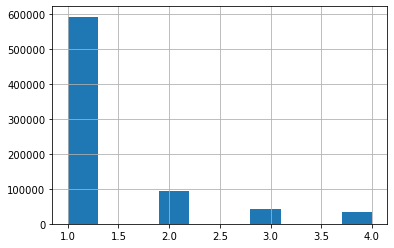

In [23]:
df.erace.hist();

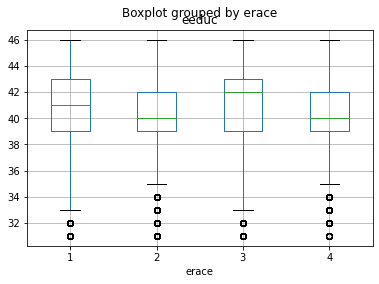

In [24]:
df.boxplot(column = ['eeduc'], by = 'erace');

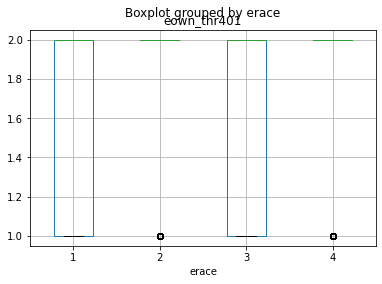

In [25]:
df.boxplot(column = ['eown_thr401'], by = 'erace');

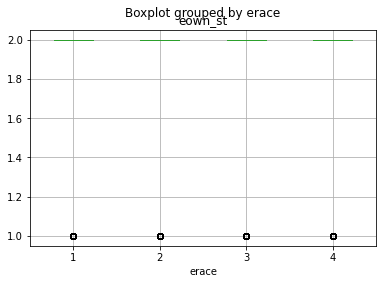

In [26]:
df.boxplot(column = ['eown_st'], by = 'erace');

In [27]:
df[['erace', 'eown_thr401', 'eown_st', 'eeduc', 'ems']].corr()

,erace,eown_thr401,eown_st,eeduc,ems
erace,1.000000,0.036794,0.061731,0.002867,0.080065
eown_thr401,0.036794,1.000000,0.163061,-0.311507,0.191793
eown_st,0.061731,0.163061,1.000000,-0.229056,0.144108
eeduc,0.002867,-0.311507,-0.229056,1.000000,-0.196764
ems,0.080065,0.191793,0.144108,-0.196764,1.000000


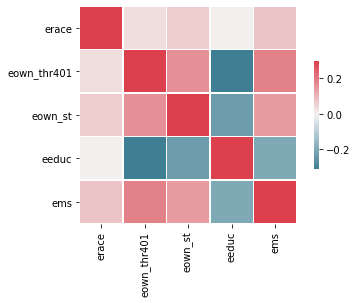

In [28]:
cmap = sns.diverging_palette(220, 10, as_cmap = True)
sns.heatmap(df[['erace', 'eown_thr401', 'eown_st', 'eeduc', 'ems']].corr(), vmax = 0.3, center = 0, cmap = cmap,
           square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5});

In [29]:
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).edebt_cc.value_counts(normalize = True).unstack().sort_values(by = 1)

edebt_cc,1,2
erace,,
3,0.267658,0.732342
2,0.314068,0.685932
1,0.320066,0.679934
4,0.320424,0.679576


In [49]:
df.ssuid.nunique()

26215

# NEW EDA

collateralized_debt = ['EBOATDEBT', 'EMCYCDEBT', 'EMHLOAN1SITE', 'EPRDEBT', 'EPRLOAN1FXVR', 'EPRLOAN1RATE',
                      'EPRLOAN1TYPE', 'ERVDEBT', 'TBOATDEBTVAL', 'TBSI1DEBTVAL', 'TMCYCDEBTVAL', 'TDEBT_BUS', 'TDEBT_HOME',
                       'TDEBT_RE', 'TDEBT_SEC', 'TDEBT_VEH', 'TPRLOANAMT', 'TRVDEBTVAL']

In [36]:
df

,ssuid,spanel,swave,etenure,eprdebt,eprloan1rate,eprloan1fxvr,eprloan1type,emhloan1site,erec_boat,...,tdebt_cc,tdebt_ed,tdebt_ot,tdebt_usec,tdebt_bus,tdebt_home,tdebt_veh,tdebt_sec,tdebt_ast,tptotinc
0,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
1,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
2,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
3,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
4,00011413607018,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,0,0,0,0,0,0,0,0,0,1738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763181,91092598868818,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
763182,91092598868818,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
763183,91092598868818,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
763184,91092598868818,2018,1,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


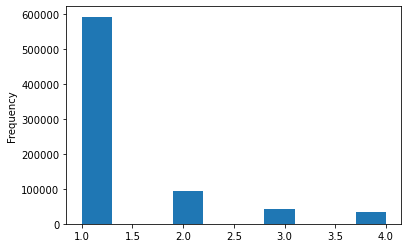

In [69]:
df['erace'].plot.hist();

eboatdebt,1,2
erace,,
3,0.240000,0.760000
4,0.119565,0.880435
1,0.099223,0.900777
2,0.083333,0.916667


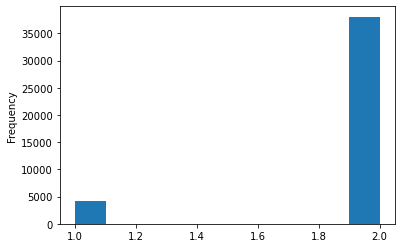

In [92]:
df['eboatdebt'].plot.hist(); #not enough respondents
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).eboatdebt.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

emcycdebt,1,2
erace,,
3,0.156627,0.843373
4,0.139073,0.860927
1,0.135822,0.864178
2,0.126667,0.873333


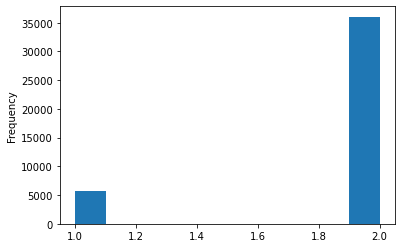

In [91]:
df['emcycdebt'].plot.hist(); #not enough respondents
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).emcycdebt.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

emhloan1site,1,2,3
erace,,,
2,0.041667,0.645833,0.312500
1,0.021242,0.436275,0.542484
3,NaN,NaN,1.000000
4,NaN,0.457143,0.542857


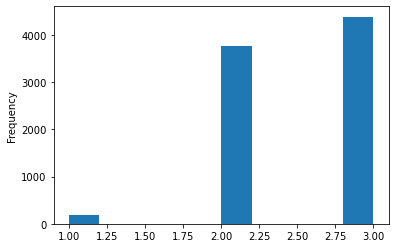

In [90]:
df['emhloan1site'].plot.hist(); #not enough respondents
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).emhloan1site.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

eprdebt,1,2
erace,,
3,0.739906,0.260094
4,0.695873,0.304127
1,0.671795,0.328205
2,0.662546,0.337454


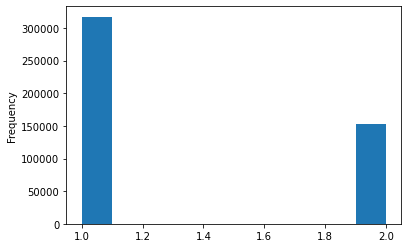

In [89]:
df['eprdebt'].plot.hist(); #check
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).eprdebt.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

eprloan1fxvr,1,2,3
erace,,,
2,0.927239,0.048507,0.024254
1,0.925264,0.055995,0.018741
3,0.922589,0.044416,0.032995
4,0.919875,0.056191,0.023933


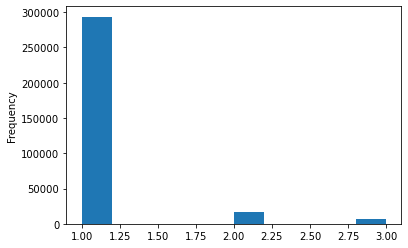

In [88]:
df['eprloan1fxvr'].plot.hist();
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).eprloan1fxvr.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

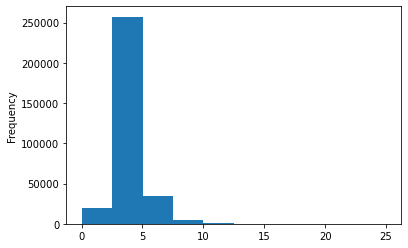

In [78]:
df['eprloan1rate'].plot.hist(); #check

eprloan1type,1,2,3,4
erace,,,,
3,0.152919,0.032360,0.219543,0.595178
1,0.197970,0.068382,0.233030,0.500617
4,0.247659,0.096774,0.262227,0.393340
2,0.340019,0.090485,0.210354,0.359142


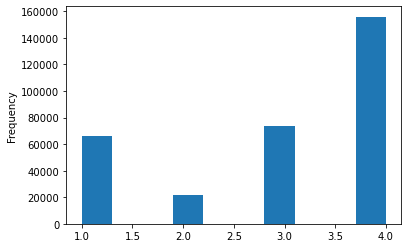

In [79]:
df['eprloan1type'].plot.hist(); #check
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).eprloan1type.value_counts(normalize = True).unstack().sort_values(by = 1)

ervdebt,1,2
erace,,
2,0.280000,0.720000
1,0.276802,0.723198
4,0.220930,0.779070
3,0.083333,0.916667


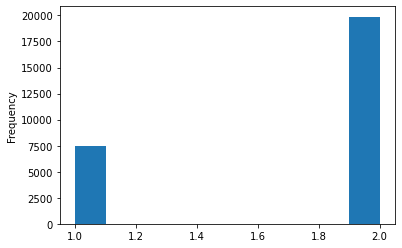

In [87]:
df['ervdebt'].plot.hist();
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).ervdebt.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

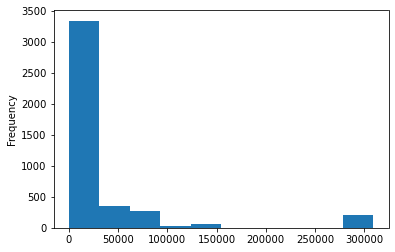

In [44]:
df['tboatdebtval'].plot.hist();

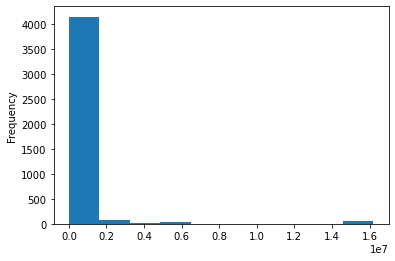

In [45]:
df['tbsi1debtval'].plot.hist(); #1.6 would be about 16m, not many respondents

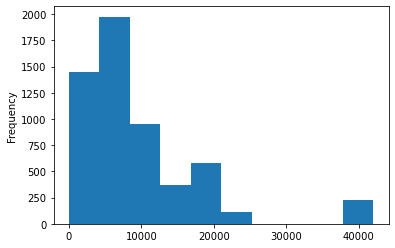

In [46]:
df['tmcycdebtval'].plot.hist(); #not many respondents

tdebt_bus,0,1,2,9,10,45,50,55,89,100,...,3835200,3900000,4730000,5148000,5184000,6671000,6673600,7520000,7559000,8401600
erace,,,,,,,,,,,,,,,,,,,,,
2,0.989315,0.000162,0.000162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000162,NaN,NaN,NaN,NaN,NaN,NaN,0.000162,NaN,NaN
3,0.981413,0.001352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000338,NaN,NaN,NaN,0.000338,NaN,NaN,NaN,NaN
1,0.977650,0.001542,0.000563,0.000024,0.000073,0.000024,0.000024,0.000024,NaN,0.000049,...,0.000024,NaN,0.000024,0.000024,0.000024,NaN,0.000024,0.000343,0.000024,0.000024
4,0.985146,0.001592,0.000531,NaN,NaN,NaN,NaN,NaN,0.000531,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


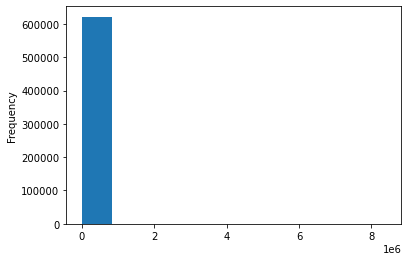

In [82]:
df['tdebt_bus'].plot.hist(); #not much debt against businesses
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).tdebt_bus.value_counts(normalize = True).unstack().sort_values(by = 1)

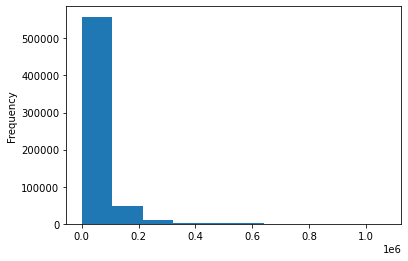

In [50]:
df['tdebt_home'].plot.hist(); #check

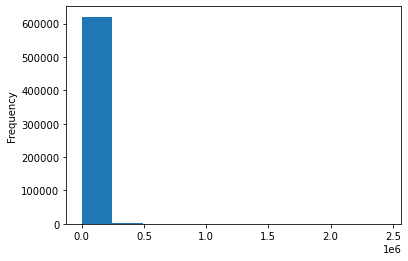

In [51]:
df['tdebt_re'].plot.hist(); #seems like a max of half a million

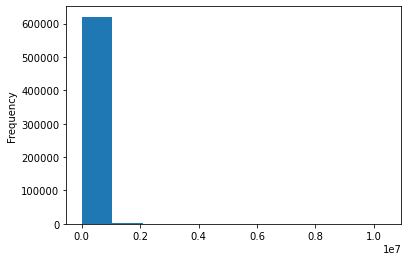

In [52]:
df['tdebt_sec'].plot.hist(); #Check! Person-level sum of all secured debt (TDEBT_HOME, TDEBT_VEH, TDEBT_RENT, TDEBT_RE, TDEBT_BUS).

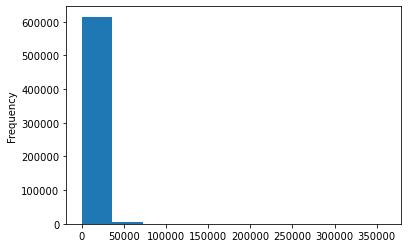

In [53]:
df['tdebt_veh'].plot.hist(); #check

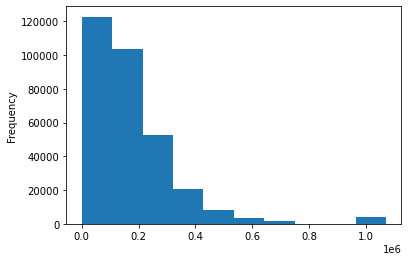

In [54]:
df['tprloanamt'].plot.hist(); #1e6 = 1million; check

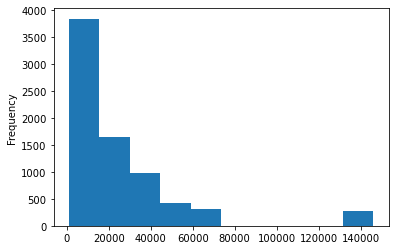

In [55]:
df['trvdebtval'].plot.hist(); #check

unsecured_debt = ['EDEBT_CC', 'EDEBT_ED', 'EDEBT_MED', 'EJSCCDEBT', 'EJSEDDEBT', 'EJSOTDEBT', 'TDEBT_CC', 'TDEBT_ED',
                 'TDEBT_OT', 'TDEBT_BUS', 'TDEBT_AST', 'TDEBT_RENT', 'TDEBT_USEC']

edebt_cc,1,2
erace,,
4,0.320424,0.679576
1,0.320066,0.679934
2,0.314068,0.685932
3,0.267658,0.732342


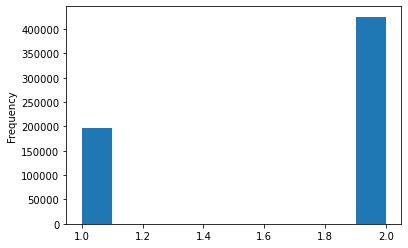

In [85]:
df['edebt_cc'].plot.hist(); #check
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).edebt_cc.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

edebt_ed,1,2
erace,,
2,0.168690,0.831310
4,0.159151,0.840849
1,0.124183,0.875817
3,0.099358,0.900642


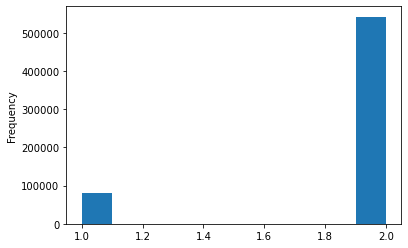

In [86]:
df['edebt_ed'].plot.hist(); #check
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).edebt_ed.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

edebt_med,1,2
erace,,
2,0.176137,0.823863
4,0.142706,0.857294
1,0.110499,0.889501
3,0.048665,0.951335


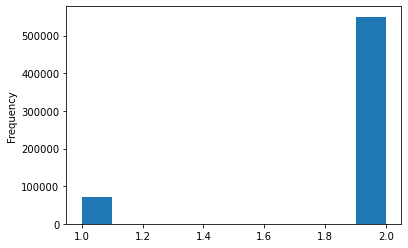

In [95]:
df['edebt_med'].plot.hist(); #check
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).edebt_med.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

ejsccdebt,1,2
erace,,
1,0.413016,0.586984
4,0.360000,0.640000
3,0.340726,0.659274
2,0.249377,0.750623


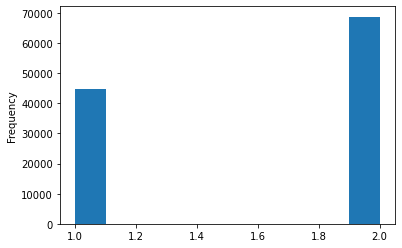

In [96]:
df['ejsccdebt'].plot.hist();
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).ejsccdebt.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

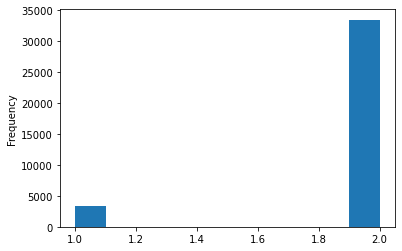

In [62]:
df['ejseddebt'].plot.hist(); #not as much info, but still check

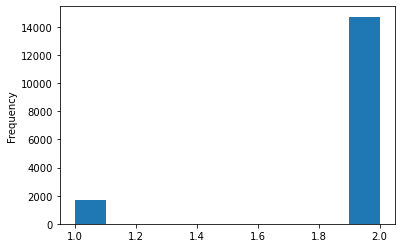

In [63]:
df['ejsotdebt'].plot.hist(); #not much info here

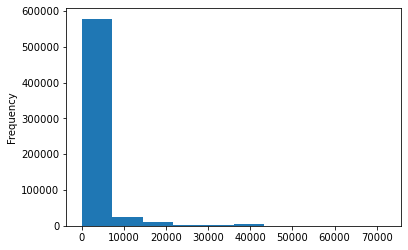

In [64]:
df['tdebt_cc'].plot.hist(); #check

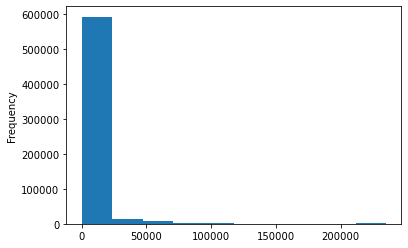

In [65]:
df['tdebt_ed'].plot.hist(); #check

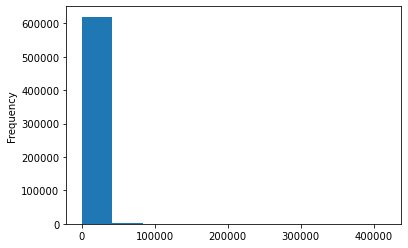

In [66]:
df['tdebt_ot'].plot.hist(); #check

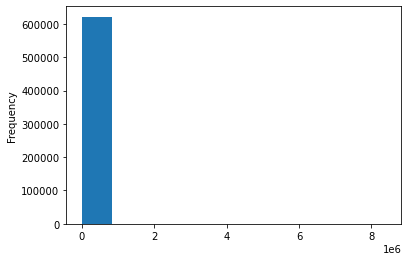

In [67]:
df['tdebt_bus'].plot.hist();

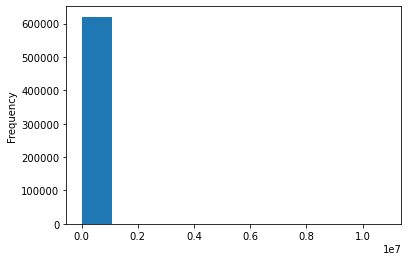

In [68]:
df['tdebt_ast'].plot.hist();

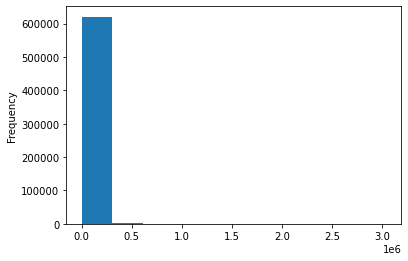

In [93]:
df['tdebt_rent'].plot.hist();

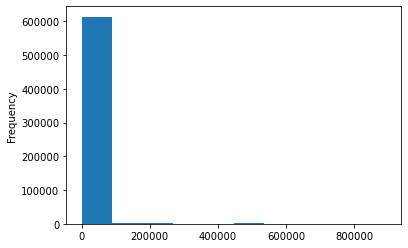

In [94]:
df['tdebt_usec'].plot.hist();

arthur_boat_bonus = ['EREC_BOAT', 'TBOATVAL']

erec_boat,1,2
erace,,
1,0.401674,0.598326
2,0.268657,0.731343
4,0.244681,0.755319
3,0.185185,0.814815


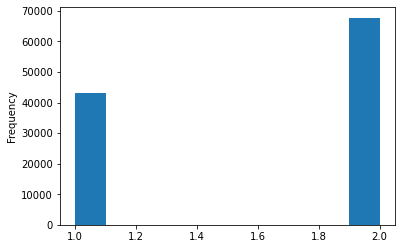

In [98]:
df['erec_boat'].plot.hist();
df.drop_duplicates(['ssuid', 'pnum']).groupby(['erace']).erec_boat.value_counts(normalize = True).unstack().sort_values(by = 1, ascending = False)

# TWO DIMENSIONAL

TypeError: No loop matching the specified signature and casting was found for ufunc add

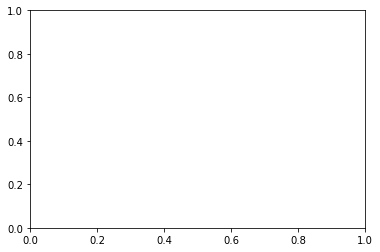

In [110]:
#sns.kdeplot(x = 'erace', y= 'tdebt_ast', data = df);

In [107]:
df[['erace', 'tdebt_ast', 'eown_thr401', 'eown_st', 'eeduc']].corr()

,erace,tdebt_ast,eown_thr401,eown_st,eeduc
erace,1.000000,-0.008511,0.036794,0.061731,0.002867
tdebt_ast,-0.008511,1.000000,-0.108608,-0.091770,0.129247
eown_thr401,0.036794,-0.108608,1.000000,0.163061,-0.311507
eown_st,0.061731,-0.091770,0.163061,1.000000,-0.229056
eeduc,0.002867,0.129247,-0.311507,-0.229056,1.000000


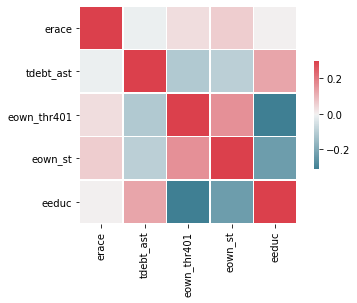

In [106]:
sns.heatmap(df[['erace', 'tdebt_ast', 'eown_thr401', 'eown_st', 'eeduc']].corr(), vmax = 0.3, center = 0, cmap = cmap,
           square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5});